In [1]:
# This R environment comes with many helpful analytics packages installed
# It is defined by the kaggle/rstats Docker image: https://github.com/kaggle/docker-rstats
# For example, here's a helpful package to load

library(tidyverse) # metapackage of all tidyverse packages
library(naniar)
library(ggplot2)
library(glmnet)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

list.files(path = "../input")

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.3     ✔ purrr   0.3.4
✔ tibble  3.1.1     ✔ dplyr   1.0.5
✔ tidyr   1.1.3     ✔ stringr 1.4.0
✔ readr   1.4.0     ✔ forcats 0.5.0

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Loading required package: Matrix


Attaching package: ‘Matrix’


The following objects are masked from ‘package:tidyr’:

    expand, pack, unpack


Loaded glmnet 3.0-2




[1] "house-prices-advanced-regression-techniques"

Loading the train and test data

In [2]:
home_data_train <- read.csv('../input/house-prices-advanced-regression-techniques/train.csv', stringsAsFactors = TRUE)
home_data_test <- read.csv('../input/house-prices-advanced-regression-techniques/test.csv', stringsAsFactors = TRUE)

In [3]:
summary(home_data_train$SalePrice)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  34900  129975  163000  180921  214000  755000 

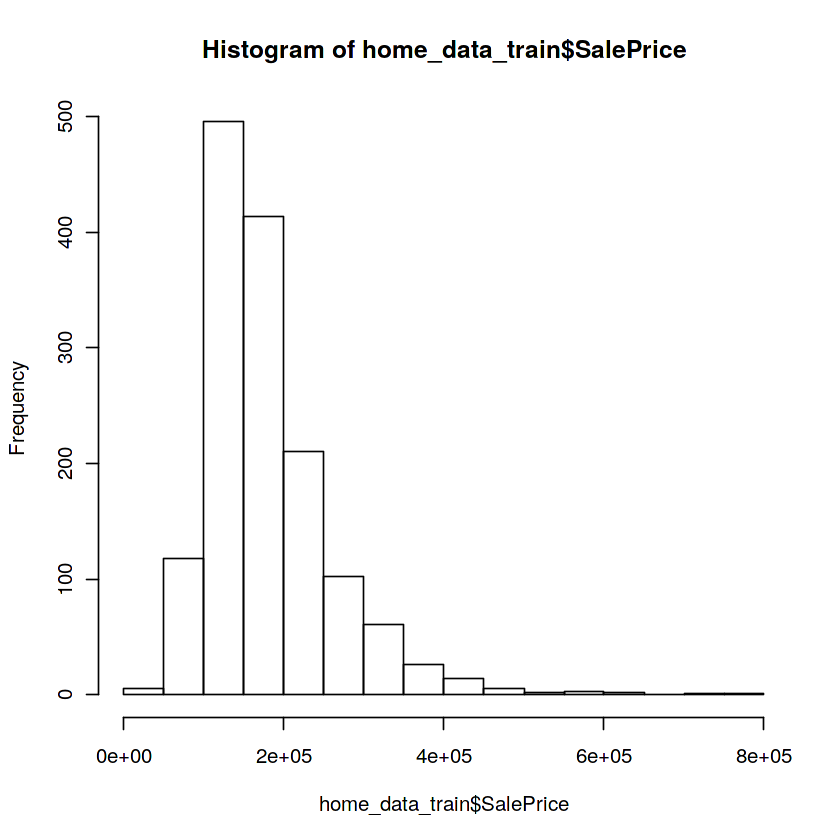

In [4]:
hist(home_data_train$SalePrice)

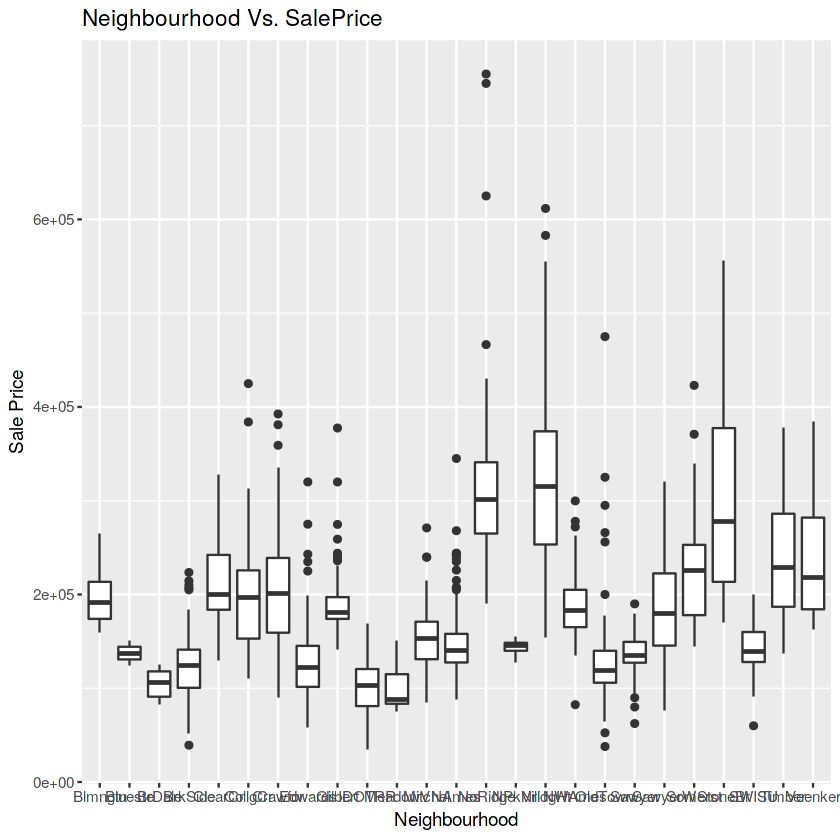

In [5]:
ggplot(home_data_train, aes(x=Neighborhood, y=SalePrice)) + geom_boxplot() + xlab ("Neighbourhood") + ylab("Sale Price") + ggtitle("Neighbourhood Vs. SalePrice")

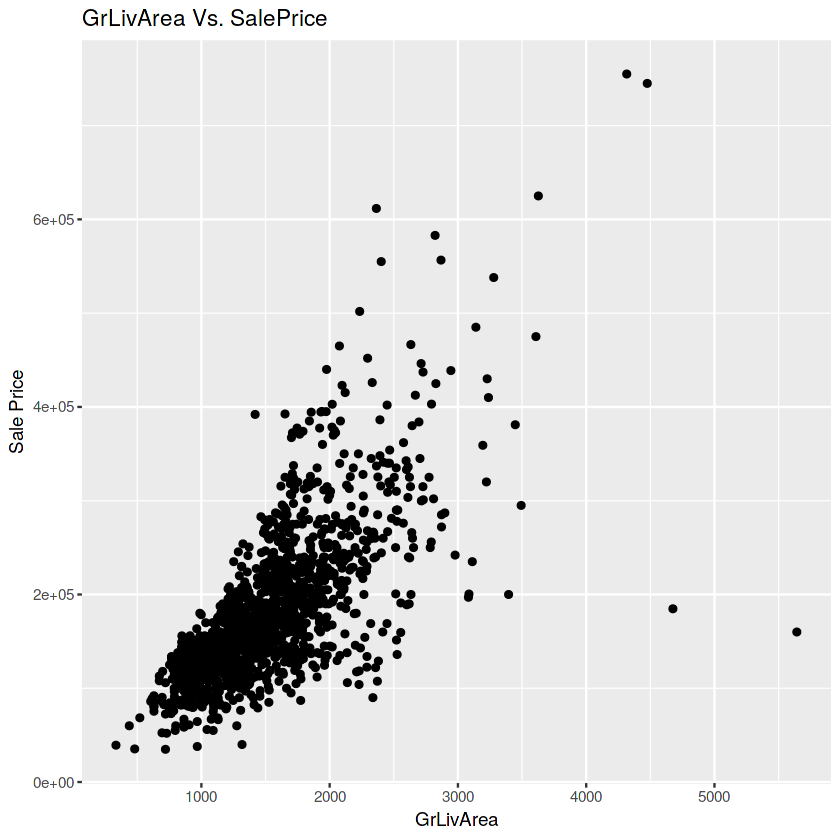

In [6]:
ggplot(home_data_train, aes(x=GrLivArea, y=SalePrice)) + geom_point() + xlab ("GrLivArea") + ylab("Sale Price") + ggtitle("GrLivArea Vs. SalePrice")

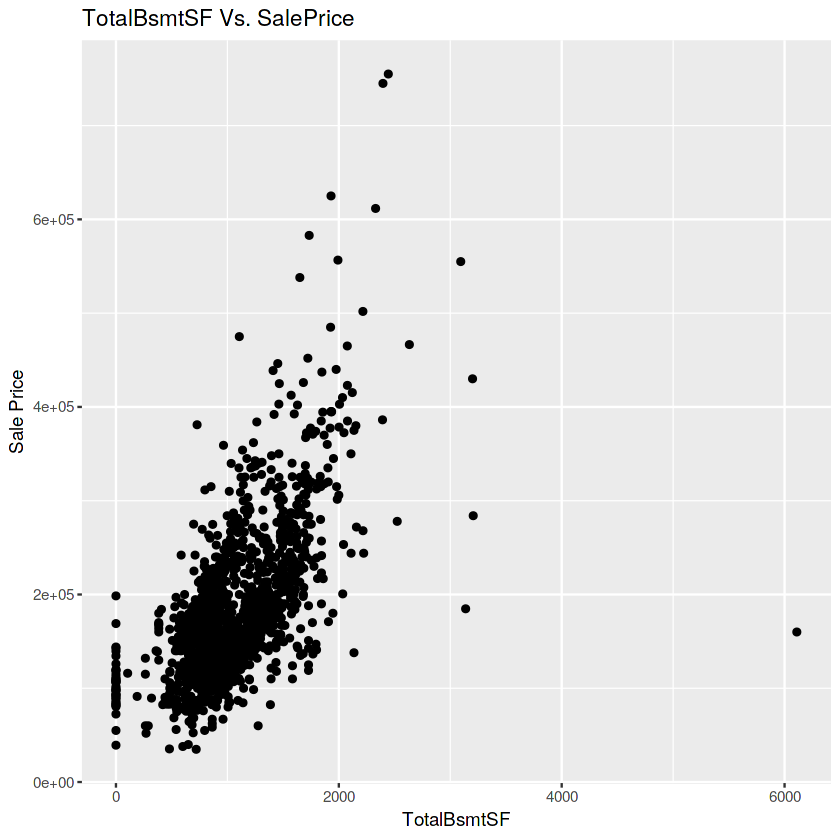

In [7]:
ggplot(home_data_train, aes(x=TotalBsmtSF, y=SalePrice)) + geom_point() + xlab ("TotalBsmtSF") + ylab("Sale Price") + ggtitle("TotalBsmtSF Vs. SalePrice")

Adding the new variable 'SalePrice' in the test dataset before merging train and test dataset

In [8]:
home_data_test$SalePrice <- 0

home_data <- rbind(home_data_train, home_data_test)

A quick look at the first 6 observations in the dataset

In [9]:
head(home_data)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,⋯,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
,<int>,<int>,<fct>,<int>,<int>,<fct>,<fct>,<fct>,<fct>,<fct>,⋯,<int>,<fct>,<fct>,<fct>,<int>,<int>,<int>,<fct>,<fct>,<dbl>
1,1,60,RL,65,8450,Pave,NA,Reg,Lvl,AllPub,⋯,0,NA,NA,NA,0,2,2008,WD,Normal,208500
2,2,20,RL,80,9600,Pave,NA,Reg,Lvl,AllPub,⋯,0,NA,NA,NA,0,5,2007,WD,Normal,181500
3,3,60,RL,68,11250,Pave,NA,IR1,Lvl,AllPub,⋯,0,NA,NA,NA,0,9,2008,WD,Normal,223500
4,4,70,RL,60,9550,Pave,NA,IR1,Lvl,AllPub,⋯,0,NA,NA,NA,0,2,2006,WD,Abnorml,140000
5,5,60,RL,84,14260,Pave,NA,IR1,Lvl,AllPub,⋯,0,NA,NA,NA,0,12,2008,WD,Normal,250000
6,6,50,RL,85,14115,Pave,NA,IR1,Lvl,AllPub,⋯,0,NA,MnPrv,Shed,700,10,2009,WD,Normal,143000


Taking a look at the structure of the dataset

In [10]:
str(home_data)

'data.frame':	2919 obs. of  81 variables:
 $ Id           : int  1 2 3 4 5 6 7 8 9 10 ...
 $ MSSubClass   : int  60 20 60 70 60 50 20 60 50 190 ...
 $ MSZoning     : Factor w/ 5 levels "C (all)","FV",..: 4 4 4 4 4 4 4 4 5 4 ...
 $ LotFrontage  : int  65 80 68 60 84 85 75 NA 51 50 ...
 $ LotArea      : int  8450 9600 11250 9550 14260 14115 10084 10382 6120 7420 ...
 $ Street       : Factor w/ 2 levels "Grvl","Pave": 2 2 2 2 2 2 2 2 2 2 ...
 $ Alley        : Factor w/ 2 levels "Grvl","Pave": NA NA NA NA NA NA NA NA NA NA ...
 $ LotShape     : Factor w/ 4 levels "IR1","IR2","IR3",..: 4 4 1 1 1 1 4 1 4 4 ...
 $ LandContour  : Factor w/ 4 levels "Bnk","HLS","Low",..: 4 4 4 4 4 4 4 4 4 4 ...
 $ Utilities    : Factor w/ 2 levels "AllPub","NoSeWa": 1 1 1 1 1 1 1 1 1 1 ...
 $ LotConfig    : Factor w/ 5 levels "Corner","CulDSac",..: 5 3 5 1 3 5 5 1 5 1 ...
 $ LandSlope    : Factor w/ 3 levels "Gtl","Mod","Sev": 1 1 1 1 1 1 1 1 1 1 ...
 $ Neighborhood : Factor w/ 25 levels "Blmngtn","Blueste",..:

Checking for missingness in the data

In [11]:
anyNA(home_data)

[1] TRUE

Taking a look at the missing data and the percentages

In [12]:
miss_var_summary(home_data)

variable,n_miss,pct_miss
<chr>,<int>,<dbl>
PoolQC,2909,99.65741692
MiscFeature,2814,96.40287770
Alley,2721,93.21685509
Fence,2348,80.43850634
FireplaceQu,1420,48.64679685
LotFrontage,486,16.64953751
GarageYrBlt,159,5.44707091
GarageFinish,159,5.44707091
GarageQual,159,5.44707091


Handling the Missing Data

1. Handling the missing data in Ordinal Categorical Variables

Missing Data in "PoolQC" Variable

A quick look at the unique values in the "PoolQC" variable

In [13]:
levels(home_data$PoolQC)

[1] "Ex" "Fa" "Gd"

PoolQC: Pool quality
		
       Ex	Excellent
       Gd	Good
       TA	Average/Typical
       Fa	Fair
       NA	No Pool

Updating the missing data in PoolQC with "No" as NAs denote "No Pool"

In [14]:
home_data$PoolQC <- factor(home_data$PoolQC, levels=c(levels(home_data$PoolQC), "No"))
home_data$PoolQC[is.na(home_data$PoolQC)] <- "No"

Missing Data in "MiscFeature" Variable

A quick look at the unique values in the "MiscFeature" variable

In [15]:
levels(home_data$MiscFeature)

[1] "Gar2" "Othr" "Shed" "TenC"

MiscFeature: Miscellaneous feature not covered in other categories
		
       Elev	Elevator
       Gar2	2nd Garage (if not described in garage section)
       Othr	Other
       Shed	Shed (over 100 SF)
       TenC	Tennis Court
       NA	None

Updating the missing data in MiscFeature with "No" as NAs denote "MiscFeature"

In [16]:
home_data$MiscFeature = factor(home_data$MiscFeature, levels=c(levels(home_data$MiscFeature), "None"))

home_data$MiscFeature[is.na(home_data$MiscFeature)] = "None"

Missing Data in "Alley" Variable

A quick at the unique values in "Alley" Variable

In [17]:
levels(home_data$Alley)

[1] "Grvl" "Pave"

Alley: Type of alley access to property

       Grvl	Gravel
       Pave	Paved
       NA 	No alley access

Updating the missing data in Alley with "No" as NAs denote "No Alley Access"

In [18]:
home_data$Alley = factor(home_data$Alley, levels=c(levels(home_data$Alley), "No"))

home_data$Alley[is.na(home_data$Alley)] = "No"

Missing Data in "Fence" Variable

A quick at the unique values in "Fence" Variable

In [19]:
levels(home_data$Fence)

[1] "GdPrv" "GdWo"  "MnPrv" "MnWw"

Fence: Fence quality
		
       GdPrv	Good Privacy
       MnPrv	Minimum Privacy
       GdWo	Good Wood
       MnWw	Minimum Wood/Wire
       NA	No Fence

Updating the missing data in Fence with "No" as NAs denote "No Fence"

In [20]:
home_data$Fence = factor(home_data$Fence, levels=c(levels(home_data$Fence), "No"))

home_data$Fence[is.na(home_data$Fence)] = "No"

Missing Data in "FirePlaceQu" Variable

A quick at the unique values in "FirePlaceQu" Variable

In [21]:
levels(home_data$FireplaceQu)

[1] "Ex" "Fa" "Gd" "Po" "TA"

FireplaceQu: Fireplace quality

       Ex	Excellent - Exceptional Masonry Fireplace
       Gd	Good - Masonry Fireplace in main level
       TA	Average - Prefabricated Fireplace in main living area or Masonry Fireplace in basement
       Fa	Fair - Prefabricated Fireplace in basement
       Po	Poor - Ben Franklin Stove
       NA	No Fireplace

Updating the missing data in FireplaceQu with "No" as NAs denote "No Fireplace"

In [22]:
home_data$FireplaceQu = factor(home_data$FireplaceQu, levels=c(levels(home_data$FireplaceQu), "No"))

home_data$FireplaceQu[is.na(home_data$FireplaceQu)] = "No"

Missing Data in "GarageType" Variable

A quick at the unique values in "GarageType" Variable

In [23]:
levels(home_data$GarageType)

[1] "2Types"  "Attchd"  "Basment" "BuiltIn" "CarPort" "Detchd"

GarageType: Garage location
		
       2Types	More than one type of garage
       Attchd	Attached to home
       Basment	Basement Garage
       BuiltIn	Built-In (Garage part of house - typically has room above garage)
       CarPort	Car Port
       Detchd	Detached from home
       NA	No Garage

Updating the missing data in GarageType with "No" as NAs denote "No Garage"

In [24]:
home_data$GarageType = factor(home_data$GarageType, levels=c(levels(home_data$GarageType), "No"))

home_data$GarageType[is.na(home_data$GarageType)] = "No"

Missing Data in "GarageFinish" Variable

A quick at the unique values in "GarageFinish" Variable

In [25]:
levels(home_data$GarageFinish)

[1] "Fin" "RFn" "Unf"

GarageFinish: Interior finish of the garage

       Fin	Finished
       RFn	Rough Finished	
       Unf	Unfinished
       NA	No Garage

Updating the missing data in GarageFinish with "No" as NAs denote "No Garage"

In [26]:
home_data$GarageFinish = factor(home_data$GarageFinish, levels=c(levels(home_data$GarageFinish), "No"))

home_data$GarageFinish[is.na(home_data$GarageFinish)] = "No"


Missing Data in "GarageQual" Variable

A quick at the unique values in "GarageQual" Variable

In [27]:
levels(home_data$GarageQual)

[1] "Ex" "Fa" "Gd" "Po" "TA"

GarageQual: Garage quality

       Ex	Excellent
       Gd	Good
       TA	Typical/Average
       Fa	Fair
       Po	Poor
       NA	No Garage

Updating the missing data in GarageQual with "No" as NAs denote "No Garage"

In [28]:
home_data$GarageQual = factor(home_data$GarageQual, levels=c(levels(home_data$GarageQual), "No"))

home_data$GarageQual[is.na(home_data$GarageQual)] = "No"

Missing Data in "GarageCond" Variable

A quick at the unique values in "GarageCond" Variable

In [29]:
levels(home_data$GarageCond)

[1] "Ex" "Fa" "Gd" "Po" "TA"

GarageCond: Garage condition

       Ex	Excellent
       Gd	Good
       TA	Typical/Average
       Fa	Fair
       Po	Poor
       NA	No Garage

Updating the missing data in GarageCond with "No" as NAs denote "No Garage"

In [30]:
home_data$GarageCond = factor(home_data$GarageCond, levels=c(levels(home_data$GarageCond), "No"))

home_data$GarageCond[is.na(home_data$GarageCond)] = "No"

Missing Data in "BsmtExposure" Variable

A quick at the unique values in "BsmtExposure" Variable

In [31]:
levels(home_data$BsmtExposure)

[1] "Av" "Gd" "Mn" "No"

BsmtExposure: Refers to walkout or garden level walls

       Gd	Good Exposure
       Av	Average Exposure (split levels or foyers typically score average or above)	
       Mn	Mimimum Exposure
       No	No Exposure
       NA	No Basement

Updating the missing data in BsmtExposure with "No" as NAs denote "No Basement"

In [32]:
home_data$BsmtExposure[is.na(home_data$BsmtExposure)] = "No"

Missing Data in "BsmtFinType1" Variable

A quick at the unique values in "BsmtFinType1" Variable

In [33]:
levels(home_data$BsmtFinType1)

[1] "ALQ" "BLQ" "GLQ" "LwQ" "Rec" "Unf"

BsmtFinType1: Rating of basement finished area

       GLQ	Good Living Quarters
       ALQ	Average Living Quarters
       BLQ	Below Average Living Quarters	
       Rec	Average Rec Room
       LwQ	Low Quality
       Unf	Unfinshed
       NA	No Basement

Updating the missing data in BsmtFinType1 with "No" as NAs denote "No Basement"

In [34]:
home_data$BsmtFinType1 = factor(home_data$BsmtFinType1, levels=c(levels(home_data$BsmtFinType1), "No"))

home_data$BsmtFinType1[is.na(home_data$BsmtFinType1)] = "No"

Missing Data in "BsmtFinType2" Variable

A quick at the unique values in "BsmtFinType2" Variable

In [35]:
levels(home_data$BsmtFinType2)

[1] "ALQ" "BLQ" "GLQ" "LwQ" "Rec" "Unf"

BsmtFinType2: Rating of basement finished area (if multiple types)

       GLQ	Good Living Quarters
       ALQ	Average Living Quarters
       BLQ	Below Average Living Quarters	
       Rec	Average Rec Room
       LwQ	Low Quality
       Unf	Unfinshed
       NA	No Basement

Updating the missing data in BsmtFinType2 with "No" as NAs denote "No Basement"

In [36]:
home_data$BsmtFinType2 = factor(home_data$BsmtFinType2, levels=c(levels(home_data$BsmtFinType2), "No"))

home_data$BsmtFinType2[is.na(home_data$BsmtFinType2)] = "No"

Missing Data in "BsmtQual" Variable

A quick at the unique values in "BsmtQual" Variable

In [37]:
levels(home_data$BsmtQual)

[1] "Ex" "Fa" "Gd" "TA"

BsmtQual: Evaluates the height of the basement

       Ex	Excellent (100+ inches)	
       Gd	Good (90-99 inches)
       TA	Typical (80-89 inches)
       Fa	Fair (70-79 inches)
       Po	Poor (<70 inches
       NA	No Basement

Updating the missing data in BsmtQual with "No" as NAs denote "No Basement"

In [38]:
home_data$BsmtQual = factor(home_data$BsmtQual, levels=c(levels(home_data$BsmtQual), "No"))

home_data$BsmtQual[is.na(home_data$BsmtQual)] = "No"

Missing Data in "BsmtCond" Variable

A quick at the unique values in "BsmtCond" Variable

In [39]:
levels(home_data$BsmtCond)

[1] "Fa" "Gd" "Po" "TA"

BsmtCond: Evaluates the general condition of the basement

       Ex	Excellent
       Gd	Good
       TA	Typical - slight dampness allowed
       Fa	Fair - dampness or some cracking or settling
       Po	Poor - Severe cracking, settling, or wetness
       NA	No Basement

Updating the missing data in BsmtCond with "No" as NAs denote "No Basement"

In [40]:
home_data$BsmtCond = factor(home_data$BsmtCond, levels=c(levels(home_data$BsmtCond), "No"))

home_data$BsmtCond[is.na(home_data$BsmtCond)] = "No"

Missing Data in "MasVnrType" Variable

A quick at the unique values in "MasVnrType" Variable

In [41]:
levels(home_data$MasVnrType)

[1] "BrkCmn"  "BrkFace" "None"    "Stone"

MasVnrType: Masonry veneer type

       BrkCmn	Brick Common
       BrkFace	Brick Face
       CBlock	Cinder Block
       None	None
       Stone	Stone

Updating the missing data in MasVnrType with "No" as NAs denote "None"

In [42]:
home_data$MasVnrType = factor(home_data$MasVnrType, levels=c(levels(home_data$MasVnrType), "No"))

home_data$MasVnrType[is.na(home_data$MasVnrType)] = "No"

Missing Data in "Electrical" Variable

A quick at the unique values in "Electrical" Variable

In [43]:
levels(home_data$Electrical)

[1] "FuseA" "FuseF" "FuseP" "Mix"   "SBrkr"

Electrical: Electrical system

       SBrkr	Standard Circuit Breakers & Romex
       FuseA	Fuse Box over 60 AMP and all Romex wiring (Average)	
       FuseF	60 AMP Fuse Box and mostly Romex wiring (Fair)
       FuseP	60 AMP Fuse Box and mostly knob & tube wiring (poor)
       Mix	Mixed

Updating the missing data in Electrical with "No" as NAs denote "Unknown"

In [44]:
home_data$Electrical = factor(home_data$Electrical, levels=c(levels(home_data$Electrical), "UNKNOWN"))
home_data$Electrical[is.na(home_data$Electrical)] = "UNKNOWN"

2. Handling Missing Data in Numerical Variables

Assuming there is no Masonry veneer area, Frontage area, Basement finished Type 1 area, Basement finished Type 2 area, Basement Unfinished area, Basement area, Basement Full Bath, Basement Half Bath, Garage Cars and Garage area

In [45]:
home_data$MasVnrArea[is.na(home_data$MasVnrArea)] <-  0

home_data$LotFrontage[is.na(home_data$LotFrontage)] <-  0

home_data$BsmtFinSF1[is.na(home_data$BsmtFinSF1)] <- 0

home_data$BsmtFinSF2[is.na(home_data$BsmtFinSF2)] <- 0

home_data$BsmtUnfSF[is.na(home_data$BsmtUnfSF)] <- 0

home_data$TotalBsmtSF[is.na(home_data$TotalBsmtSF)] <- 0

home_data$BsmtFullBath[is.na(home_data$BsmtFullBath)] <- 0

home_data$BsmtHalfBath[is.na(home_data$BsmtHalfBath)] <- 0

home_data$GarageCars[is.na(home_data$GarageCars)] <- 0

home_data$GarageArea[is.na(home_data$GarageArea)] <- 0

3. Handling Missing Data in Categorical Varaibles (True Missing Data)

Most frequent value will be used to used to impute the missing data

In [46]:
home_data$KitchenQual[is.na(home_data$KitchenQual)] <- tail(names(sort(table(home_data$KitchenQual))), 1)

home_data$MSZoning[is.na(home_data$MSZoning)] <- tail(names(sort(table(home_data$MSZoning))), 1)

home_data$SaleType[is.na(home_data$SaleType)] <- tail(names(sort(table(home_data$SaleType))), 1)

home_data$Exterior1st[is.na(home_data$Exterior1st)] <- tail(names(sort(table(home_data$Exterior1st))), 1)

home_data$Exterior2nd[is.na(home_data$Exterior2nd)] <- tail(names(sort(table(home_data$Exterior2nd))), 1)

home_data$Functional[is.na(home_data$Functional)] <- tail(names(sort(table(home_data$Functional))), 1)

In [47]:
home_data$GarageYrBlt[is.na(home_data$GarageYrBlt)] <- home_data$YearBuilt[is.na(home_data$GarageYrBlt)]


home_data$Utilities <- NULL

home_data$Id <- NULL

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
    334    1126    1444    1501    1744    5642 

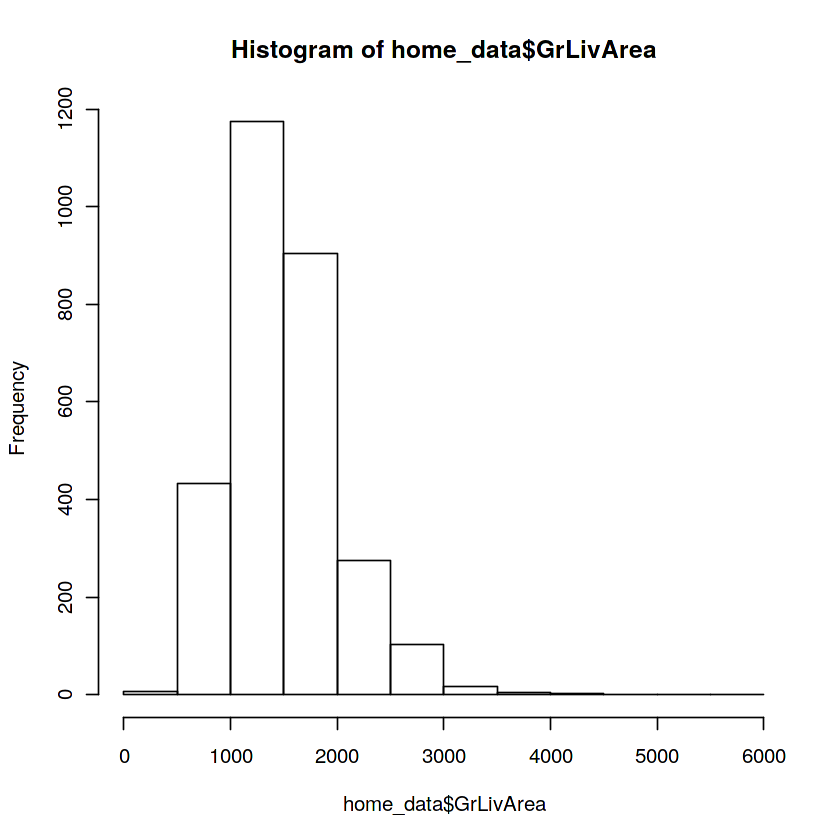

In [48]:
summary(home_data$GrLivArea) #outlier
hist(home_data$GrLivArea)
home_data$GrLivArea[home_data$GrLivArea>3500] <- as.numeric(mean(home_data$GrLivArea))

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   1300    7478    9453   10168   11570  215245 

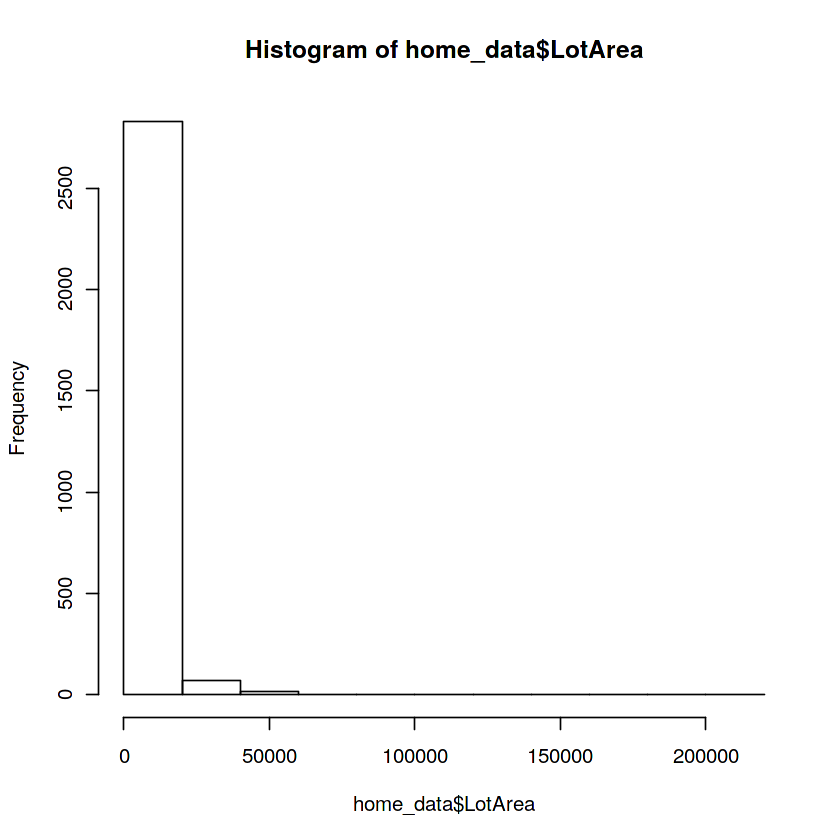

In [49]:
summary(home_data$LotArea) #outlier
hist(home_data$LotArea)
home_data$LotArea[home_data$LotArea>40000] <- as.numeric(mean(home_data$LotArea))

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
    334     876    1082    1160    1388    5095 

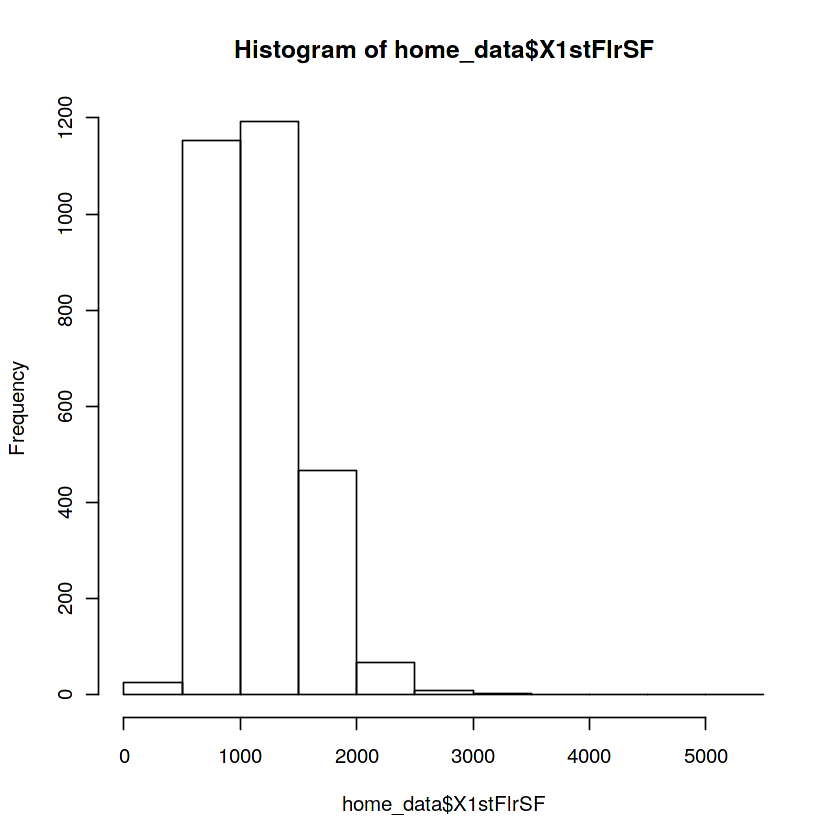

In [50]:
summary(home_data$X1stFlrSF) #outlier
hist(home_data$X1stFlrSF)
home_data$X1stFlrSF[home_data$X1stFlrSF>3000] <- as.numeric(mean(home_data$X1stFlrSF))

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
    0.0     0.0     0.0   336.5   704.0  2065.0 

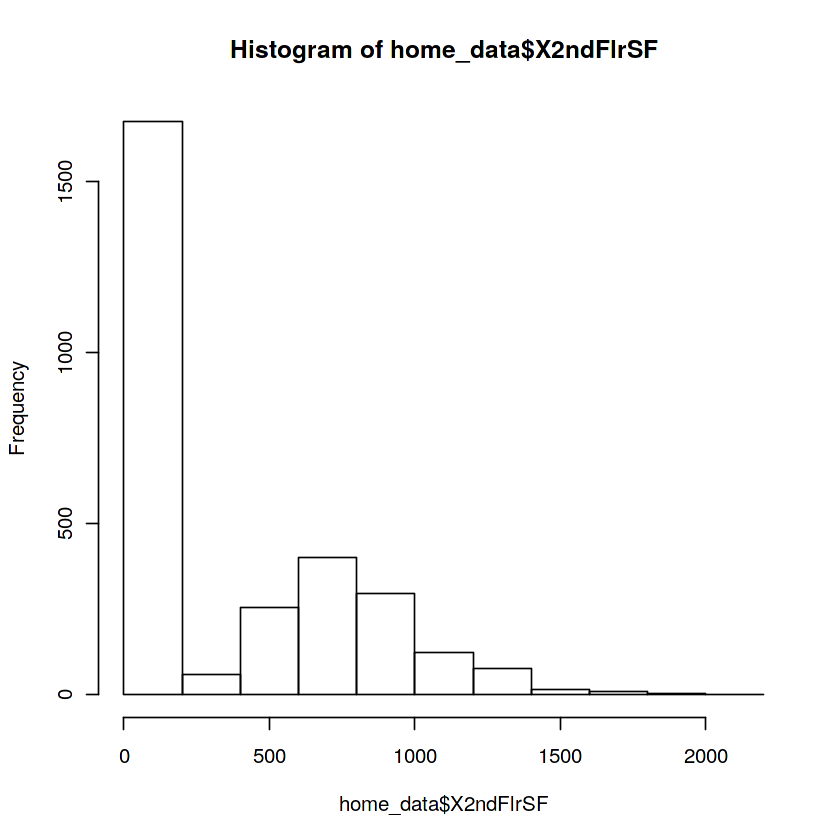

In [51]:
summary(home_data$X2ndFlrSF) #ok
hist(home_data$X2ndFlrSF)

    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
   0.000    0.000    0.000    4.694    0.000 1064.000 

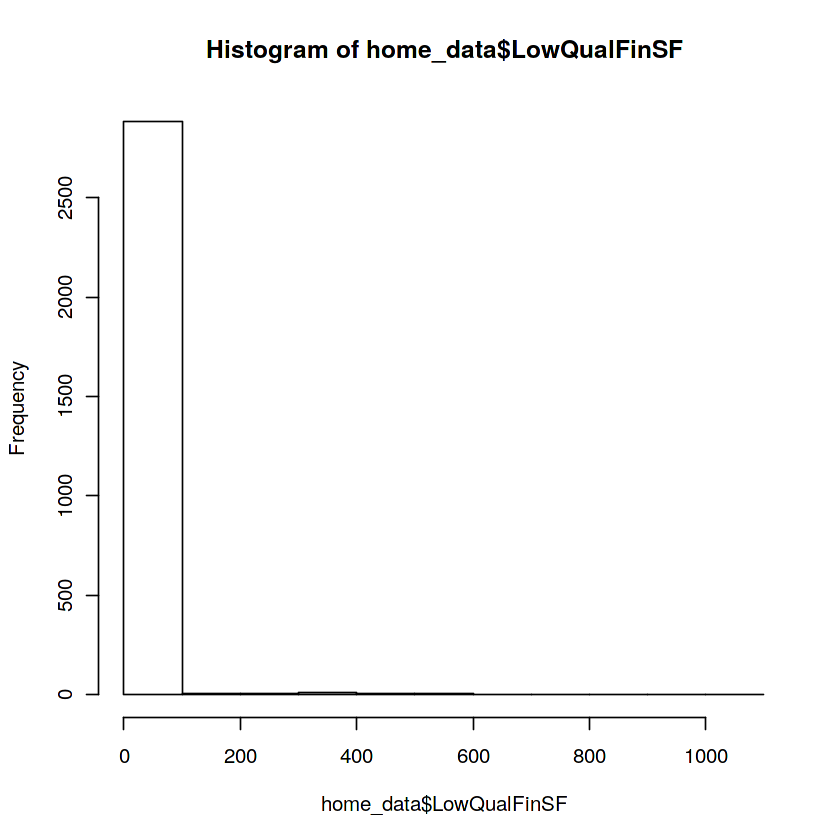

In [52]:
summary(home_data$LowQualFinSF) #outlier
hist(home_data$LowQualFinSF)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
      0     793     989    1051    1302    6110 

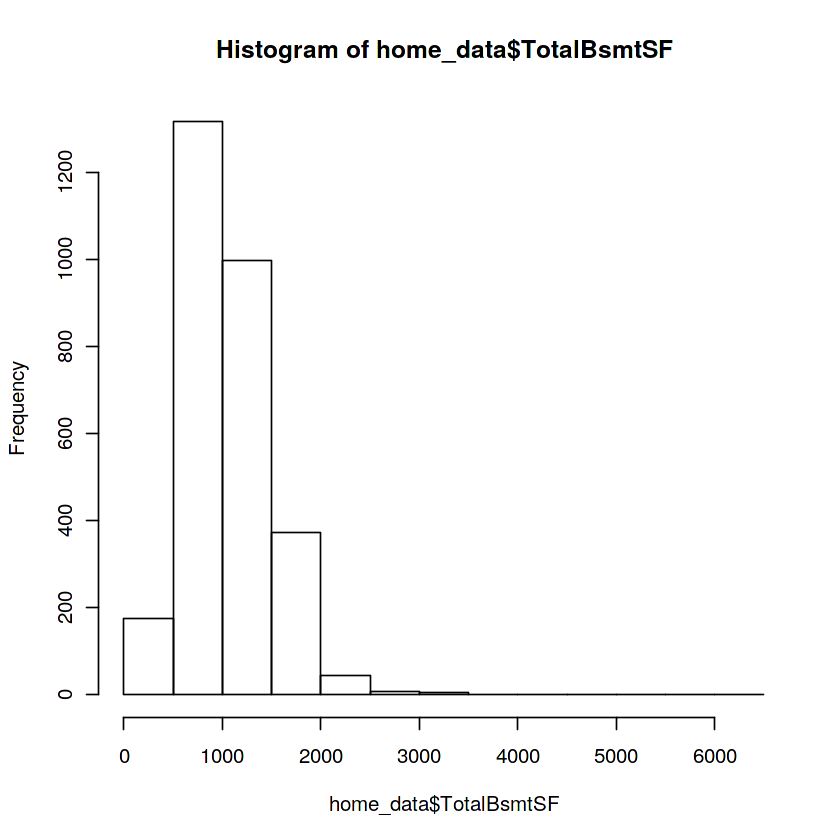

In [53]:
summary(home_data$TotalBsmtSF) #outlier
hist(home_data$TotalBsmtSF)
home_data$TotalBsmtSF[home_data$TotalBsmtSF>3000] <- as.numeric(mean(home_data$TotalBsmtSF))

    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
    0.00     0.00     0.00    50.83     0.00 17000.00 

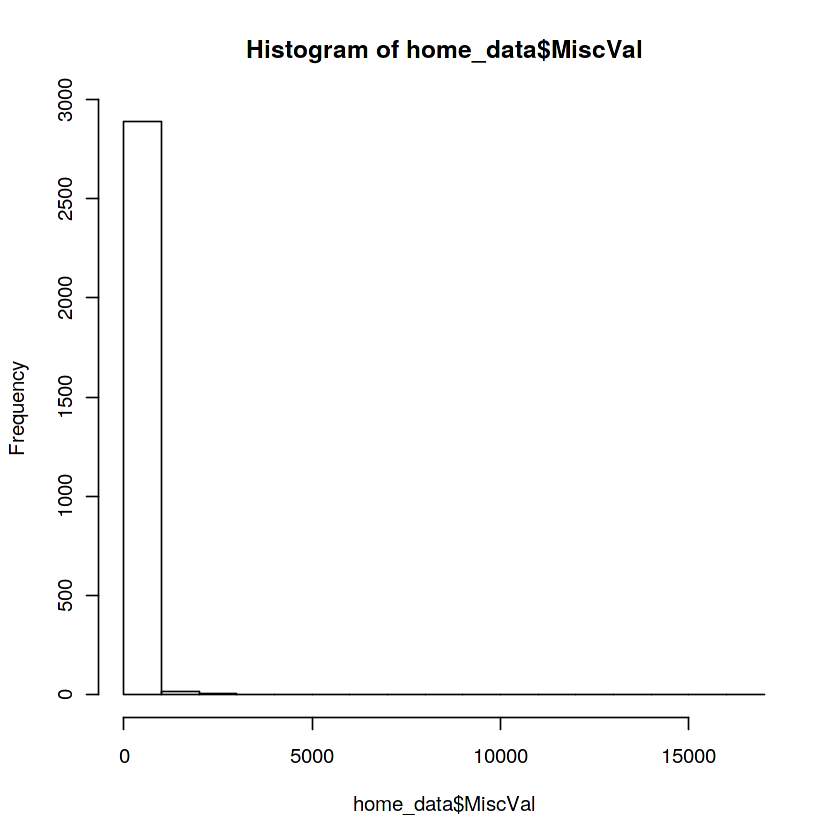

In [54]:
summary(home_data$MiscVal) #outlier
hist(home_data$MiscVal)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  1.000   5.000   6.000   6.089   7.000  10.000 

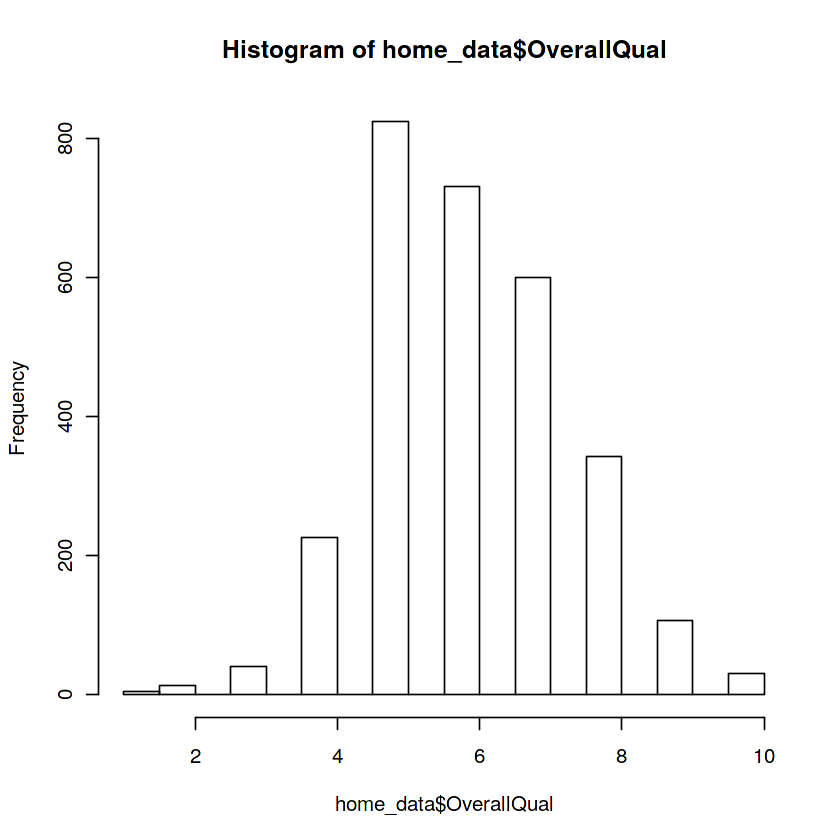

In [55]:
summary(home_data$OverallQual) #ok
hist(home_data$OverallQual)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   1872    1954    1973    1971    2001    2010 

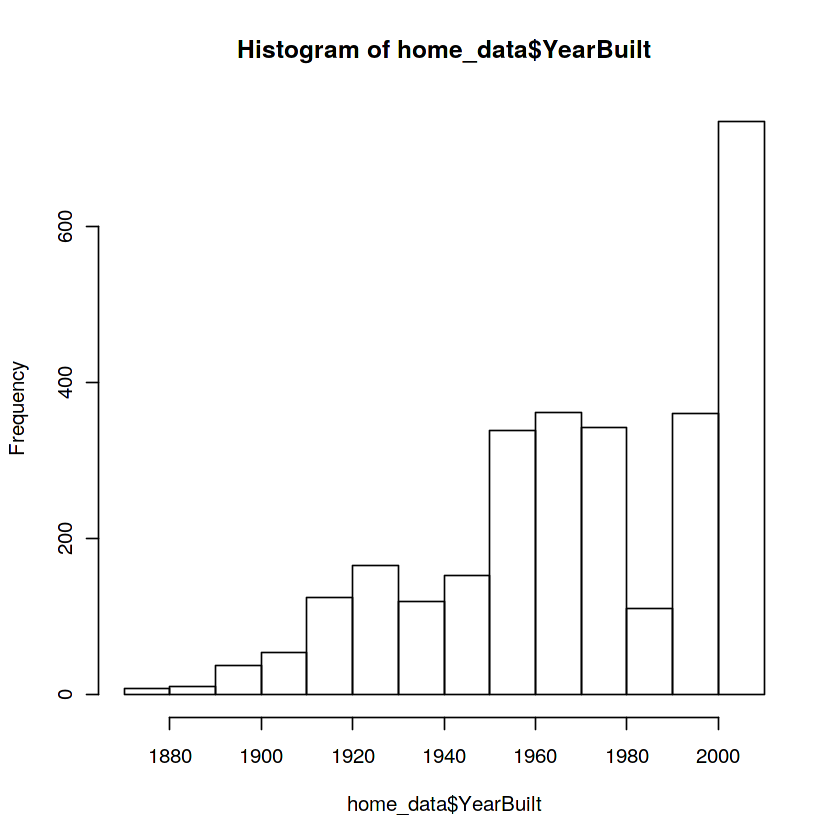

In [56]:
summary(home_data$YearBuilt) #ok
hist(home_data$YearBuilt)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   1950    1965    1993    1984    2004    2010 

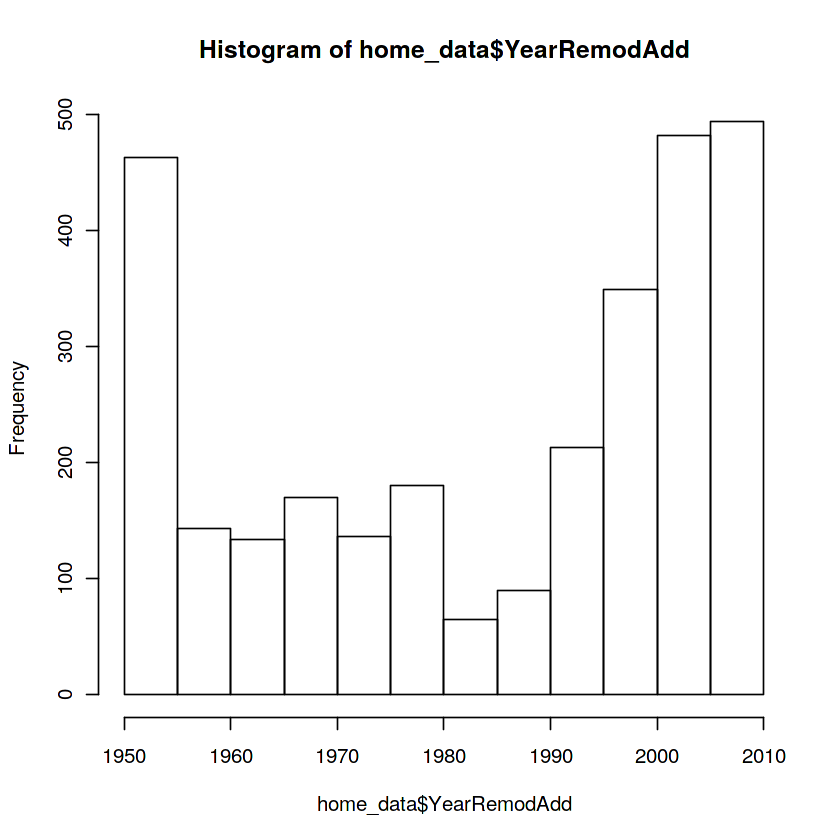

In [57]:
summary(home_data$YearRemodAdd) #ok
hist(home_data$YearRemodAdd)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  0.000   1.000   2.000   1.568   2.000   4.000 

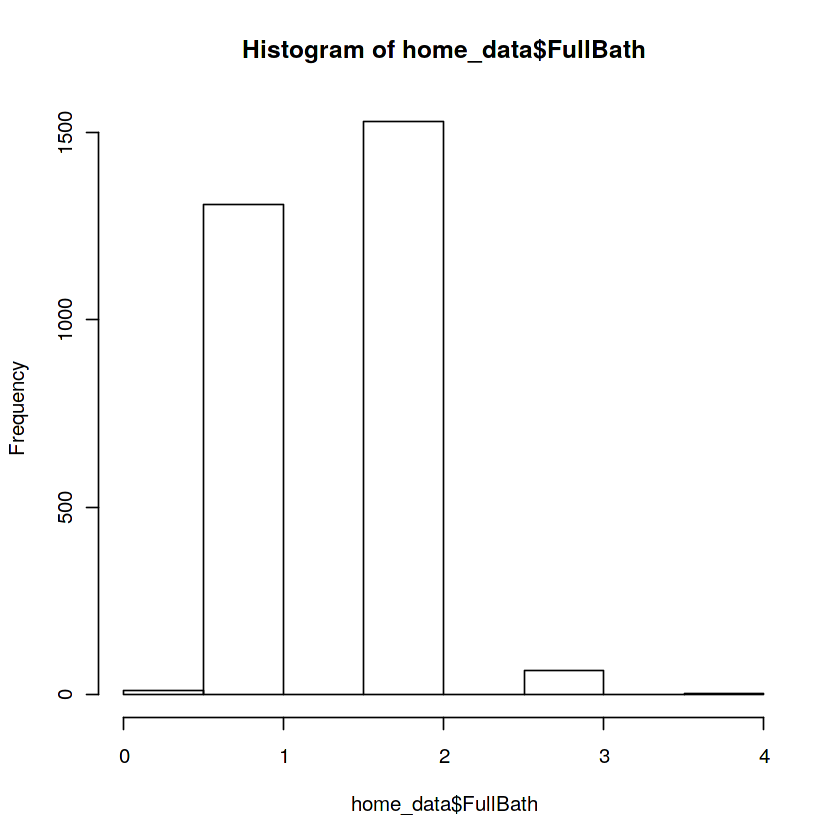

In [58]:
summary(home_data$FullBath) #ok
hist(home_data$FullBath)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  2.000   5.000   6.000   6.452   7.000  15.000 

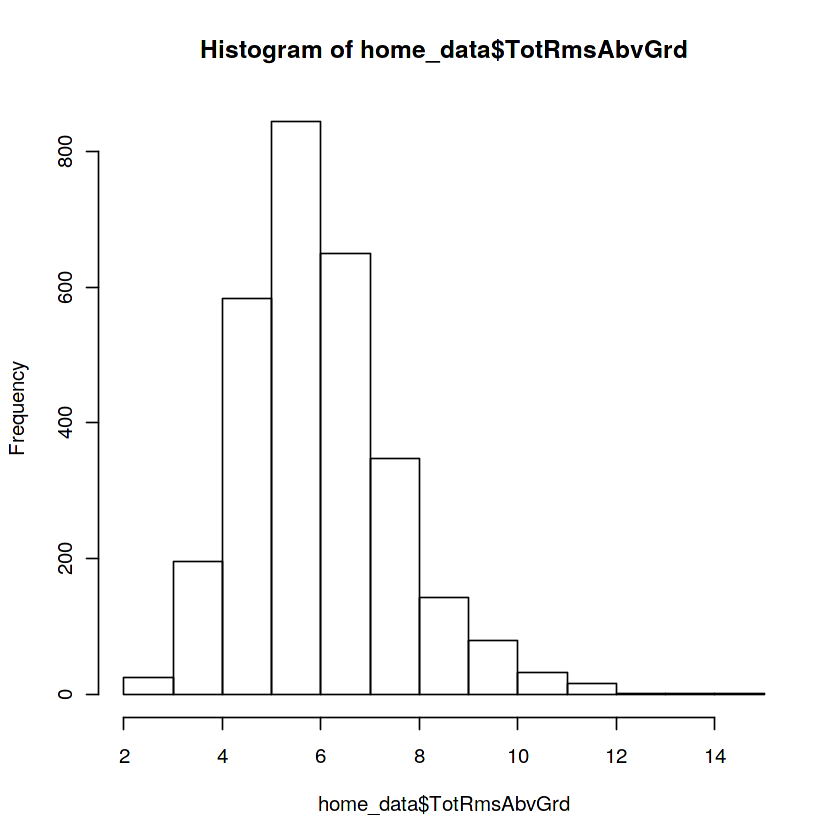

In [59]:
summary(home_data$TotRmsAbvGrd) #ok
hist(home_data$TotRmsAbvGrd)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   1872    1958    1978    1976    2001    2207 

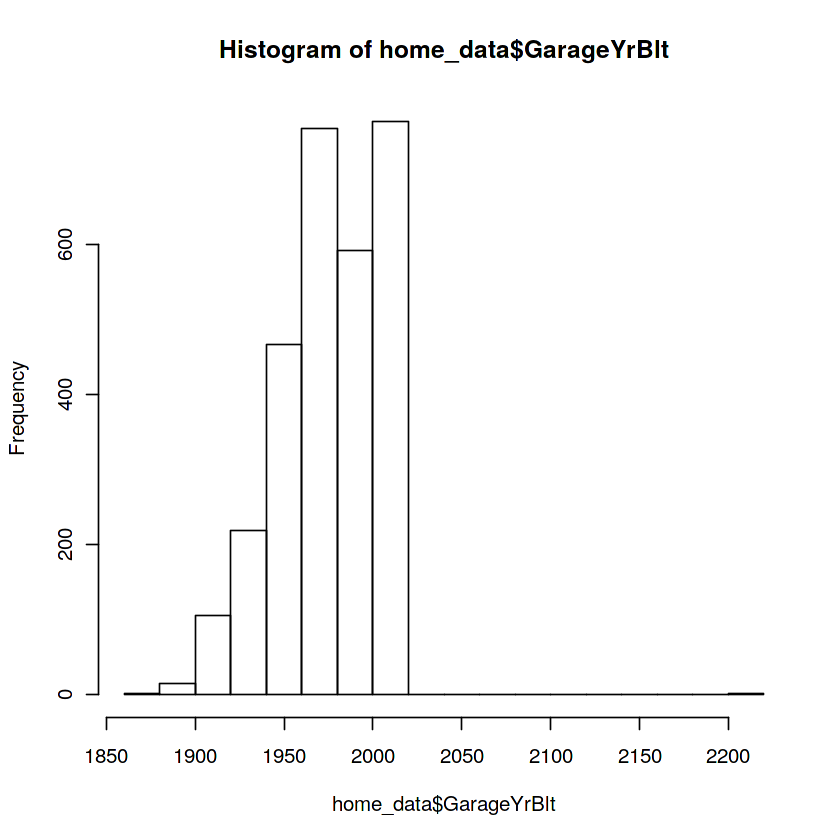

In [60]:
summary(home_data$GarageYrBlt) #ok
hist(home_data$GarageYrBlt)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  0.000   1.000   2.000   1.766   2.000   5.000 

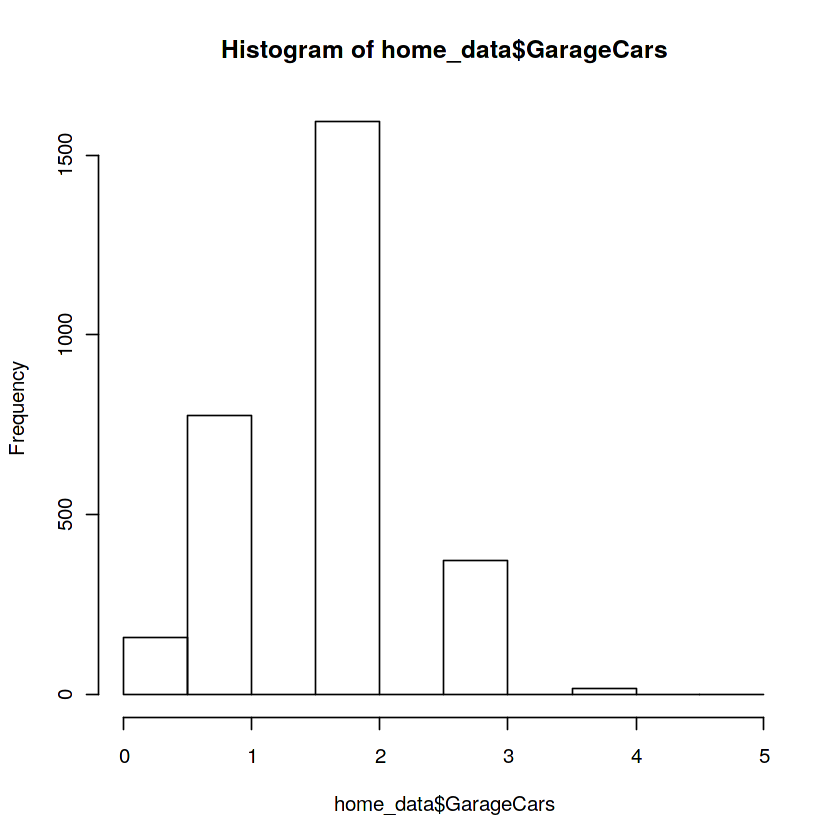

In [61]:
summary(home_data$GarageCars) #ok
hist(home_data$GarageCars)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
    0.0   320.0   480.0   472.7   576.0  1488.0 

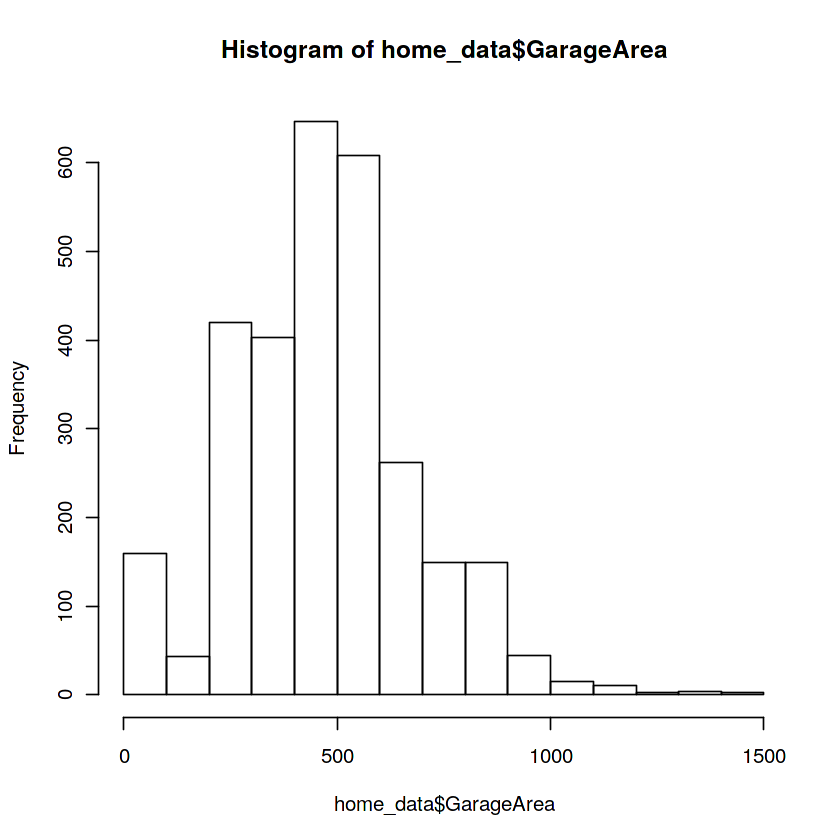

In [62]:
summary(home_data$GarageArea) #ok
hist(home_data$GarageArea)

Feature Engineering

In [63]:
# Total Area
home_data['TotalArea'] <- home_data$LotFrontage + home_data$LotArea + home_data$MasVnrArea + home_data$BsmtFinSF1 + home_data$BsmtFinSF2 + home_data$BsmtUnfSF +
               home_data$TotalBsmtSF + home_data$X1stFlrSF + home_data$X2ndFlrSF + home_data$GrLivArea + home_data$GarageArea + home_data$WoodDeckSF +  
               home_data$OpenPorchSF + home_data$EnclosedPorch + home_data$X3SsnPorch + home_data$ScreenPorch + home_data$LowQualFinSF + home_data$PoolArea


In [64]:
# To check if the house was remodeled or not?
home_data['IsRemodeled'] <- ifelse(home_data$YearRemodAdd == home_data$YearBuilt, 0, 1)

In [65]:
# Was the house remodeled after the sale or before?
home_data['IsRemodeledRecently'] <- ifelse(home_data$YearRemodAdd == home_data$YrSold, 0, 1) 

In [66]:
# To check if the house is new or not
home_data['NewHouse'] <-ifelse(home_data$YearBuilt == home_data$YrSold, 1, 0)

In [67]:
# House Age
home_data['HouseAge'] <- as.numeric(2010 - home_data$YearBuilt)

In [68]:
# Last Sold
home_data['LastSold'] <- as.numeric(2010 - home_data$YrSold)

In [69]:
# Last Remodel after sale 
home_data['TimeRemodeledSold'] <- as.numeric(home_data$YrSold - home_data$YearRemodAdd)

In [70]:
# Inside surface Area
home_data['HouseInsideSF'] <- as.numeric(home_data$X1stFlrSF + home_data$X2ndFlrSF)

In [71]:
home_data$MSSubClass <- as.factor(home_data$MSSubClass)
home_data$MoSold <- as.factor(home_data$MoSold)
home_data$YrSold <- as.factor(home_data$YrSold)

In [72]:
levels(home_data$ExterQual) # Ex	Excellent Gd	Good TA	Average/Typical Fa	Fair Po	Poor
home_data$ExterQual<- recode(home_data$ExterQual,"None"=0,"Po"=1,"Fa"=2,"TA"=3,"Gd"=4,"Ex"=6)

levels(home_data$ExterCond) # Ex	Excellent Gd	Good TA	Average/Typical Fa	Fair Po	Poor
home_data$ExterCond<- recode(home_data$ExterCond,"None"=0,"Po"=1,"Fa"=2,"TA"=3,"Gd"=4,"Ex"=6)

levels(home_data$BsmtQual) # Ex	Excellent (100+ inches)	Gd	Good (90-99 inches) TA	Typical (80-89 inches) Fa	Fair (70-79 inches) Po	Poor (<70 inches  NA	No Basement
home_data$BsmtQual<- recode(home_data$BsmtQual,"No"=0,"Po"=1,"Fa"=2,"TA"=3,"Gd"=4,"Ex"=6)

levels(home_data$BsmtCond) # Ex	Excellent Gd Good TA	Typical - slight dampness allowed Fa Fair - dampness or some cracking or settling Po	Poor - Severe cracking, settling, or wetness NA	No Basement
home_data$BsmtCond<- recode(home_data$BsmtCond,"No"=0,"Po"=1,"Fa"=2,"TA"=3,"Gd"=4,"Ex"=6)

levels(home_data$BsmtExposure) # Gd	Good Exposure Av	Average Exposure (split levels or foyers typically score average or above)	Mn	Mimimum Exposure No	No Exposure NA	No Basement
home_data$BsmtExposure<- recode(home_data$BsmtExposure,"No"=0,"No"=1,"Mn"=2,"Av"=3,"Gd"=6)

levels(home_data$BsmtFinType1) # GLQ	Good Living Quarters ALQ	Average Living Quarters BLQ	Below Average Living Quarters	Rec	Average Rec Room LwQ	Low Quality Unf	Unfinshed NA	No Basement
home_data$BsmtFinType1<- recode(home_data$BsmtFinType1,"No"=0,"Unf"=1,"LwQ"=2,"Rec"=3,"BLQ"=4,"ALQ"=5,"GLQ"=6)

levels(home_data$BsmtFinType2) # GLQ	Good Living Quarters ALQ	Average Living Quarters BLQ	Below Average Living Quarters	Rec	Average Rec Room LwQ	Low Quality Unf	Unfinshed NA	No Basement
home_data$BsmtFinType2<- recode(home_data$BsmtFinType2,"No"=0,"Unf"=1,"LwQ"=2,"Rec"=3,"BLQ"=4,"ALQ"=5,"GLQ"=6)

levels(home_data$HeatingQC) # Ex	Excellent Gd	Good TA	Average/Typical Fa	Fair Po	Poor
home_data$HeatingQC<- recode(home_data$HeatingQC,"None"=0,"Po"=1,"Fa"=2,"TA"=3,"Gd"=4,"Ex"=5)

levels(home_data$KitchenQual) # Ex	Excellent Gd	Good TA	Average/Typical Fa	Fair Po	Poor
home_data$KitchenQual<- recode(home_data$KitchenQual,"None"=0,"Po"=1,"Fa"=2,"TA"=3,"Gd"=4,"Ex"=6)

levels(home_data$Functional) # Typ	Typical Functionality Min1	Minor Deductions 1 Min2	Minor Deductions 2 Mod	Moderate Deductions Maj1	Major Deductions 1 Maj2	Major Deductions 2 Sev	Severely Damaged Sal	Salvage only
home_data$Functional<- recode(home_data$Functional,"None"=0,"Sev"=1,"Maj2"=2,"Maj1"=3,"Mod"=4,"Min2"=5,"Min1"=6,"Typ"=7)

levels(home_data$FireplaceQu) # Ex	Excellent - Exceptional Masonry Fireplace Gd	Good - Masonry Fireplace in main level TA	Average - Prefabricated Fireplace in main living area or Masonry Fireplace in basement Fa	Fair - Prefabricated Fireplace in basement Po	Poor - Ben Franklin Stove NA	No Fireplace
home_data$FireplaceQu<- recode(home_data$FireplaceQu,"No"=0,"Po"=1,"Fa"=2,"TA"=3,"Gd"=4,"Ex"=6)

levels(home_data$GarageFinish) # Fin	Finished RFn	Rough Finished Unf	Unfinished NA	No Garage
home_data$GarageFinish<- recode(home_data$GarageFinish,"No"=0,"Unf"=1,"RFn"=2,"Fin"=3)

levels(home_data$GarageQual) # Ex	Excellent Gd	Good TA	Average/Typical Fa	Fair Po	Poor
home_data$GarageQual<- recode(home_data$GarageQual,"No"=0,"Po"=1,"Fa"=2,"TA"=3,"Gd"=4,"Ex"=6)

levels(home_data$GarageCond) # Ex	Excellent Gd	Good TA	Average/Typical Fa	Fair Po	Poor
home_data$GarageCond<- recode(home_data$GarageCond,"No"=0,"Po"=1,"Fa"=2,"TA"=3,"Gd"=4,"Ex"=6)

levels(home_data$PoolQC) # Ex	Excellent Gd	Good TA	Average/Typical Fa	Fair Po	Poor
home_data$PoolQC<- recode(home_data$PoolQC,"No"=0,"Po"=1,"Fa"=2,"TA"=3,"Gd"=4,"Ex"=6)

levels(home_data$Fence) # GdPrv	Good Privacy MnPrv	Minimum Privacy GdWo	Good Wood MnWw	Minimum Wood/Wire NA	No Fence
home_data$Fence<- recode(home_data$Fence,"No"=0,"MnWw"=1,"GdWo"=2,"MnPrv"=3,"GdPrv"=6)


[1] "Ex" "Fa" "Gd" "TA"

[1] "Ex" "Fa" "Gd" "Po" "TA"

[1] "Ex" "Fa" "Gd" "TA" "No"

[1] "Fa" "Gd" "Po" "TA" "No"

[1] "Av" "Gd" "Mn" "No"

[1] "ALQ" "BLQ" "GLQ" "LwQ" "Rec" "Unf" "No"

[1] "ALQ" "BLQ" "GLQ" "LwQ" "Rec" "Unf" "No"

[1] "Ex" "Fa" "Gd" "Po" "TA"

[1] "Ex" "Fa" "Gd" "TA"

[1] "Maj1" "Maj2" "Min1" "Min2" "Mod"  "Sev"  "Typ"

[1] "Ex" "Fa" "Gd" "Po" "TA" "No"

[1] "Fin" "RFn" "Unf" "No"

[1] "Ex" "Fa" "Gd" "Po" "TA" "No"

[1] "Ex" "Fa" "Gd" "Po" "TA" "No"

[1] "Ex" "Fa" "Gd" "No"

[1] "GdPrv" "GdWo"  "MnPrv" "MnWw"  "No"

In [73]:
home_data['FenceCondB'] <- ifelse(home_data$Fence < 1, 1, 0)
home_data['GarageFinishCondB'] <- ifelse(home_data$GarageFinish < 2, 1, 0)
home_data['FunctionalB'] <- ifelse(home_data$Functional < 4, 1, 0)
home_data['BsmtFinishB1'] <- ifelse(home_data$BsmtFinType1 < 3, 1, 0)
home_data['BsmtFinishB2'] <- ifelse(home_data$BsmtFinType2 < 3, 1, 0)
home_data['ExterQualB'] <- ifelse(home_data$ExterQual < 3, 1, 0)
home_data['ExterCondlB'] <- ifelse(home_data$ExterCond < 3, 1, 0)
home_data['BsmtQualB'] <- ifelse(home_data$BsmtQual < 3, 1, 0)
home_data['BsmtCondB'] <- ifelse(home_data$BsmtCond < 3, 1, 0)
home_data['BsmtExposureB'] <- ifelse(home_data$BsmtExposure < 3, 1, 0)
home_data['HeatingQCB'] <- ifelse(home_data$HeatingQC < 3, 1, 0)
home_data['KitchenQualB'] <- ifelse(home_data$KitchenQual < 3, 1, 0)
home_data['FireplaceQuB'] <- ifelse(home_data$FireplaceQu < 3, 1, 0)
home_data['GarageQualB'] <- ifelse(home_data$GarageQual < 3, 1, 0)
home_data['GarageCondB'] <- ifelse(home_data$GarageCond < 3, 1, 0)
home_data['PoolQCBad'] <- ifelse(home_data$PoolQC < 3, 1, 0)


In [74]:
home_data['FenceCondG'] <- ifelse(home_data$Fence >= 1, 1, 0)
home_data['GarageFinishCondG'] <- ifelse(home_data$GarageFinish >= 2, 1, 0)
home_data['FunctionalG'] <- ifelse(home_data$Functional >= 4, 1, 0)
home_data['BsmtFinishG1'] <- ifelse(home_data$BsmtFinType1 >= 3, 1, 0)
home_data['BsmtFinishG2'] <- ifelse(home_data$BsmtFinType2 >= 3, 1, 0)
home_data['ExterQualG'] <- ifelse(home_data$ExterQual >= 3, 1, 0)
home_data['ExterCondlG'] <- ifelse(home_data$ExterCond >= 3, 1, 0)
home_data['BsmtQualG'] <- ifelse(home_data$BsmtQual >= 3, 1, 0)
home_data['BsmtCondG'] <- ifelse(home_data$BsmtCond >= 3, 1, 0)
home_data['BsmtExposureG'] <- ifelse(home_data$BsmtExposure >= 3, 1, 0)
home_data['HeatingQCG'] <- ifelse(home_data$HeatingQC >= 3, 1, 0)
home_data['KitchenQualG'] <- ifelse(home_data$KitchenQual >= 3, 1, 0)
home_data['FireplaceQuG'] <- ifelse(home_data$FireplaceQu >= 3, 1, 0)
home_data['GarageQualG'] <- ifelse(home_data$GarageQual >= 3, 1, 0)
home_data['GarageCondG'] <- ifelse(home_data$GarageCond >= 3, 1, 0)
home_data['IsPoolQCG'] <- ifelse(home_data$PoolQC >= 3, 1, 0)

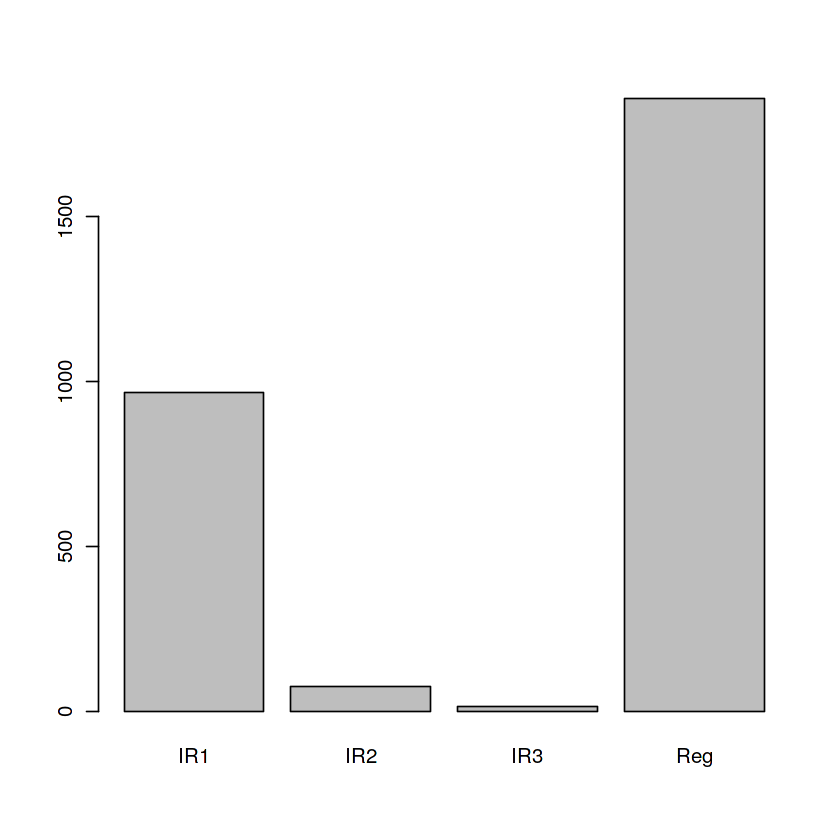

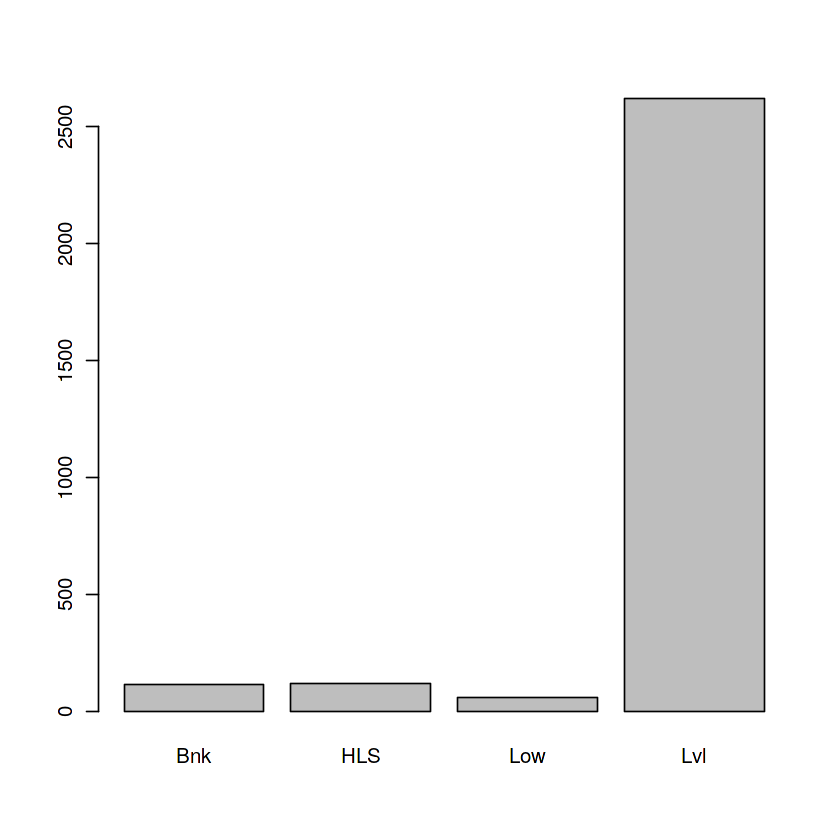

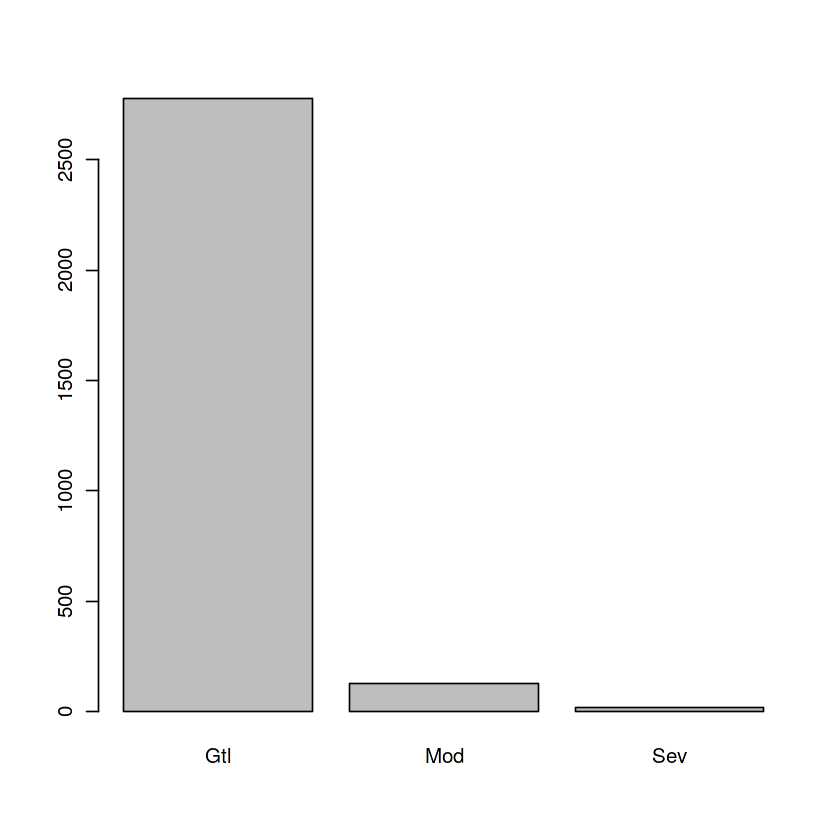

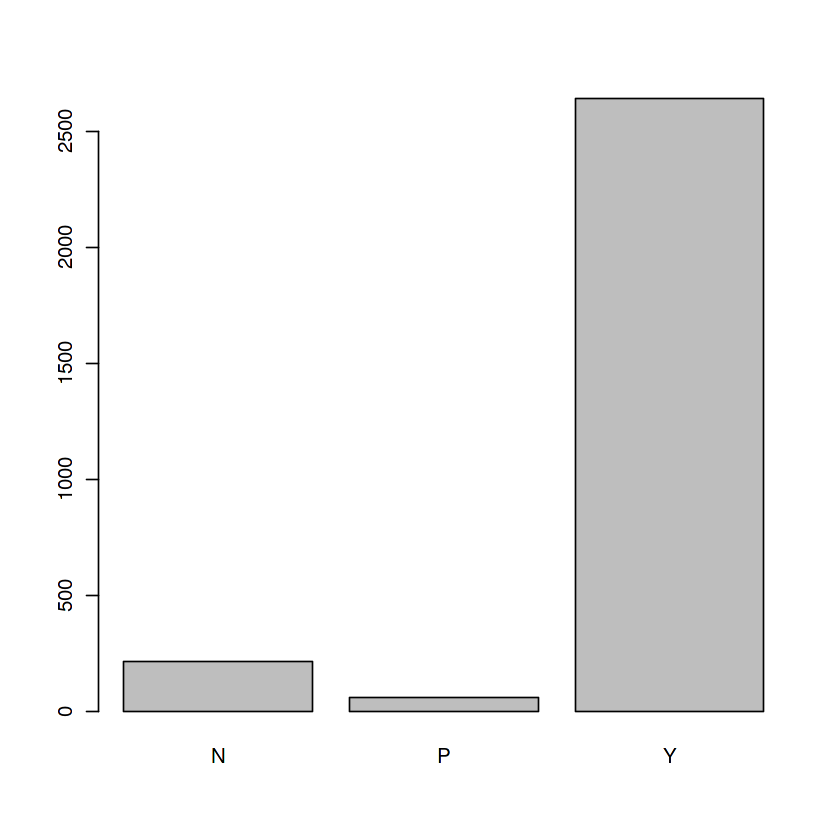

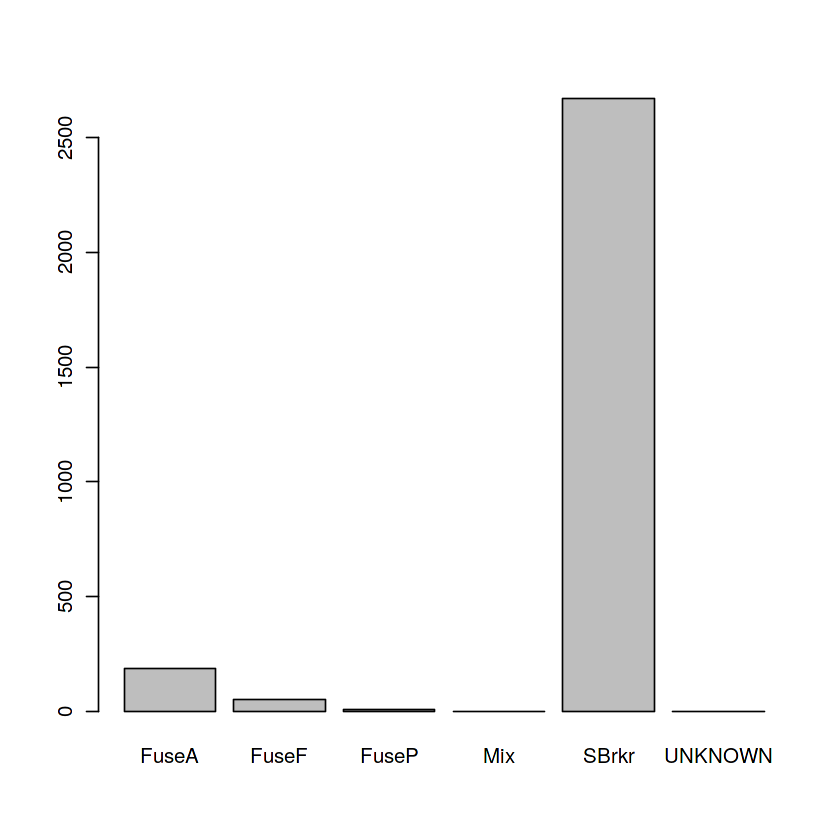

In [75]:
plot(home_data$LotShape)
home_data$RegShape <- ifelse(home_data$LotShape == 'Reg', 1, 0)

plot(home_data$LandContour)
home_data['LandContourLvl'] <- ifelse(home_data$LandContour == 'Lvl', 1, 0)

plot(home_data$LandSlope)
home_data['LandSlopeGtl'] <-  ifelse(home_data$LandSlope == 'Gtl', 1, 0)

plot(home_data$PavedDrive)
home_data['PavedDrive'] <-  ifelse(home_data$PavedDrive == 'Y', 1, 0)

plot(home_data$Electrical)
home_data['ElectricalBreaker'] <- ifelse(home_data$Electrical == 'SBrkr', 1, 0)

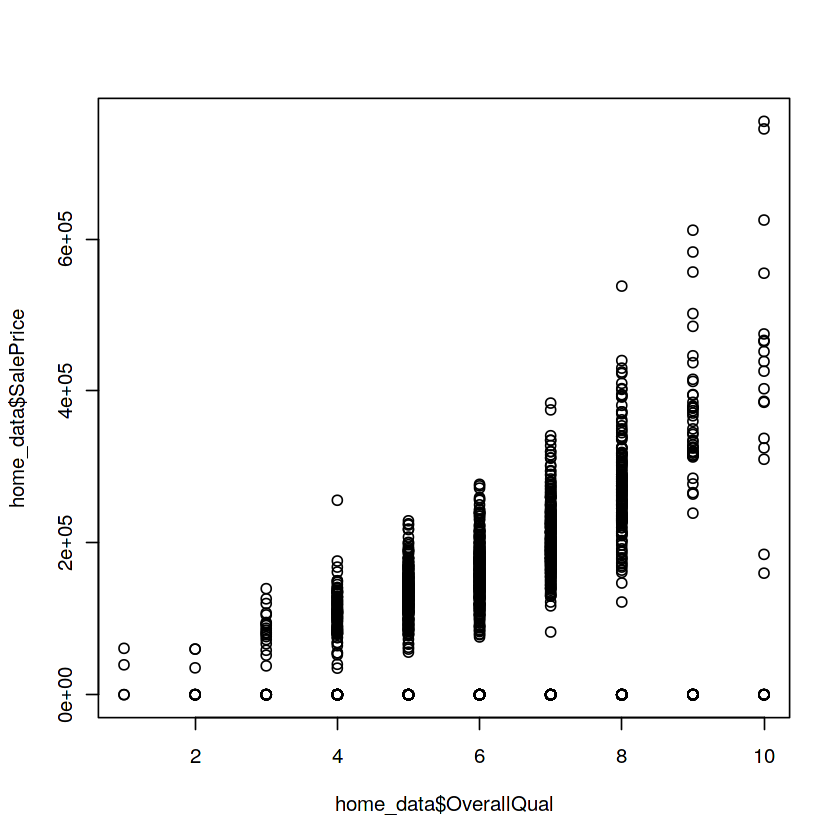

In [76]:
plot(home_data$OverallQual, home_data$SalePrice)

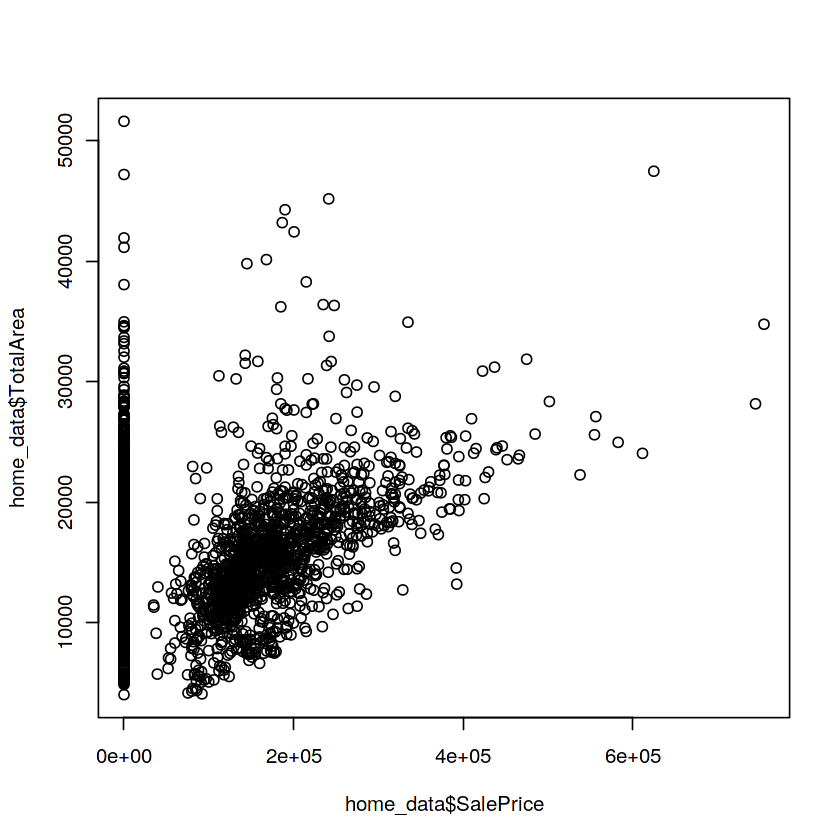

In [77]:
plot(home_data$SalePrice, home_data$TotalArea)

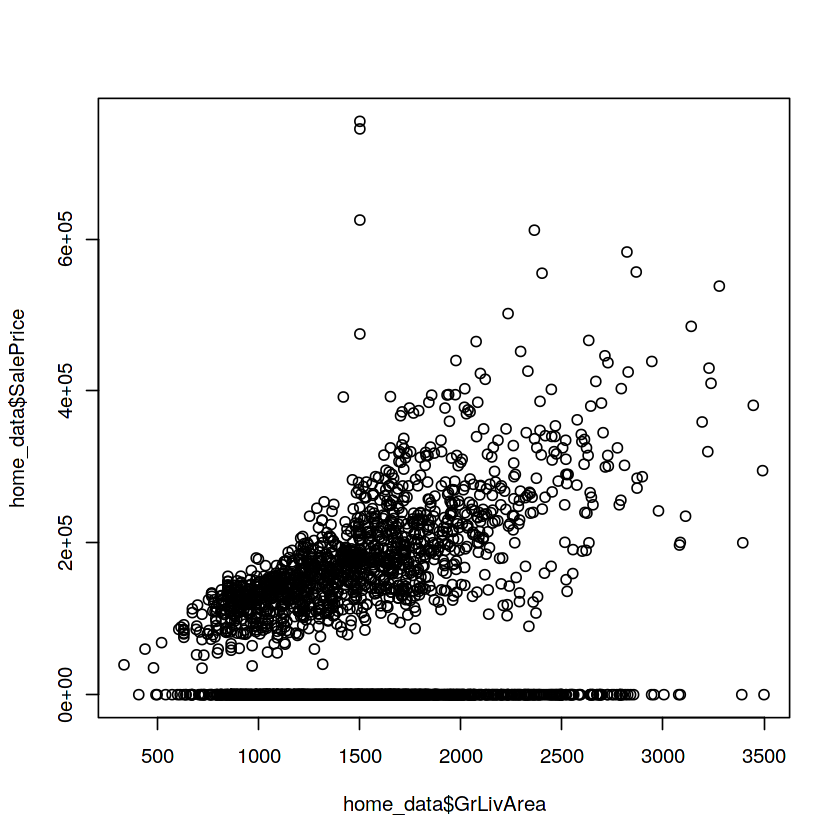

In [78]:
plot(home_data$GrLivArea, home_data$SalePrice)

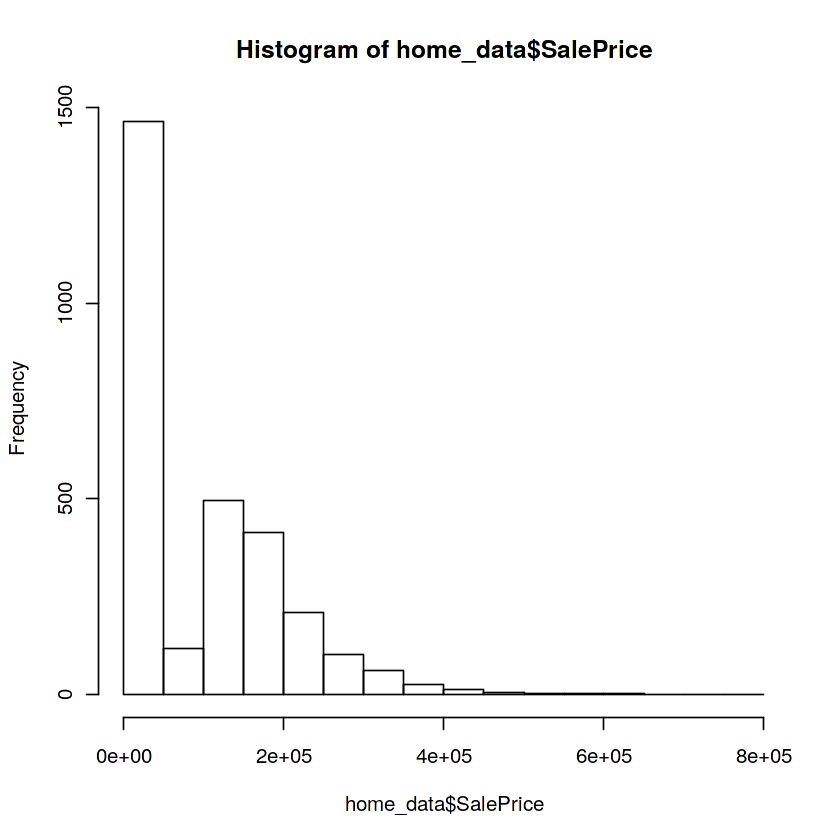

In [79]:
hist(home_data$SalePrice)

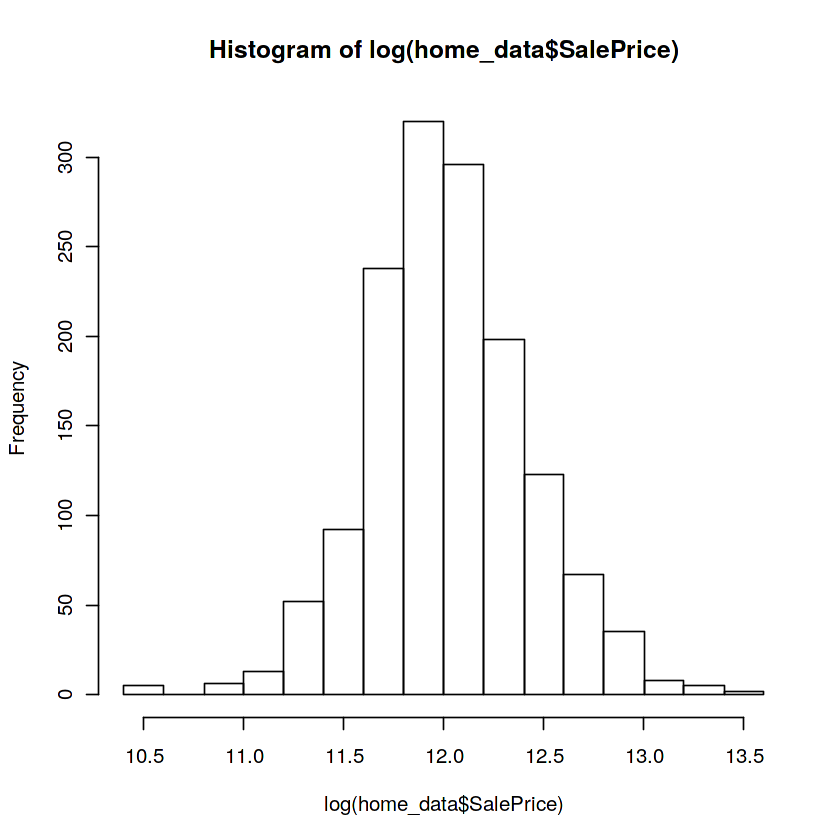

In [80]:
hist(log(home_data$SalePrice))

In [81]:
home_data$SalePrice <- log(home_data$SalePrice)

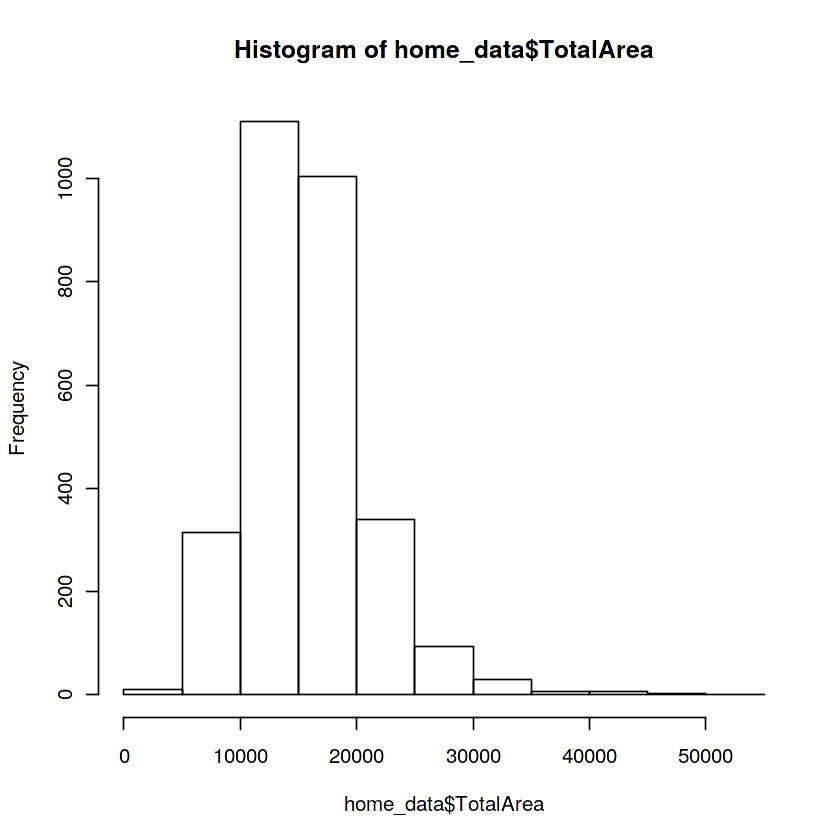

In [82]:
hist(home_data$TotalArea)

{home_data[['TotalArea']] <- log(home_data[['TotalArea']] + 1)}

In [83]:
hp_training <- home_data[1:1460,]

In [84]:
hp_test <- home_data[1461:2919,]

In [85]:
set.seed(131)
lasso <- cv.glmnet(x = data.matrix(hp_training[, - which(names(hp_training) %in% c('SalePrice'))]), y = hp_training$SalePrice, nfolds = 10)

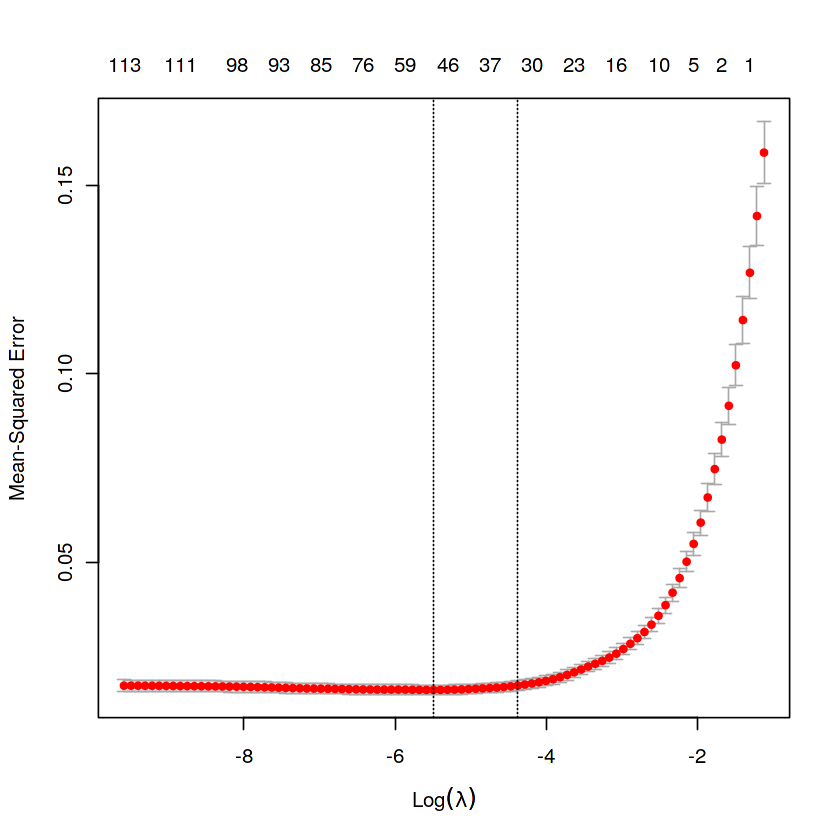

In [86]:
plot(lasso)

In [87]:
lasso$lambda.min

[1] 0.004117616

In [88]:
sqrt(lasso$cvm[lasso$lambda == lasso$lambda.min])

[1] 0.1266824

In [89]:
lasso <-  cv.glmnet(x = data.matrix(hp_training[, - which(names(hp_training) %in% c('SalePrice'))]), y = hp_training$SalePrice, nfolds = 10)
lasso_pred <- as.numeric(exp(predict(lasso, newx = data.matrix(hp_test[, - which(names(hp_test) %in% c('SalePrice'))]), s = "lambda.min"))-1)

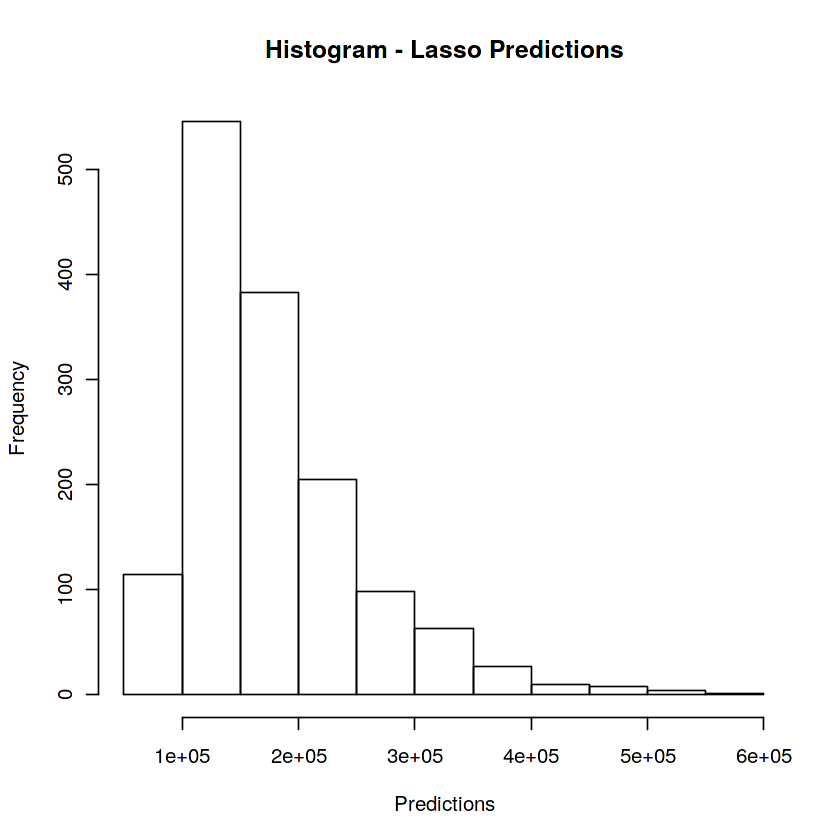

In [90]:
hist(lasso_pred, main="Histogram - Lasso Predictions", xlab = "Predictions")

In [91]:
lasso_submission <- data.frame(Id = home_data_test$Id, SalePrice= (lasso_pred))

In [92]:
colnames(lasso_submission) <-c("Id","SalePrice")

In [93]:
write.csv(lasso_submission, file = "houseprice_lasso_submission.csv", row.names = FALSE)